In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from model import MainModel, CosineWarmupScheduler, active2mask, generate_mask
from new_dataset import LocalizationDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
from ModelParams import ModelParams
from matplotlib import pyplot as plt
import matplotlib as mpl
from IPython.display import clear_output
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
params = ModelParams()
track_len = ModelParams().track_len

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

track_test = np.genfromtxt('tracks/tracks_test.csv')
world_test = np.genfromtxt('worlds/worlds_test.csv').repeat(track_len, 0).reshape(track_test.shape[0], 10, 16)

track_test_data = track_test.reshape(track_test.shape[0]//track_len, track_len, track_test.shape[1])
env_test_data = world_test.reshape(world_test.shape[0]//track_len, track_len, params.map_size, params.map_size + 6)

test_data = dict()
test_data['tracks'] = track_test_data
test_data['map'] = env_test_data

test_dataset = LocalizationDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=params.batch_size, pin_memory=True, shuffle=False)

beacons_mu, beacons_std = torch.tensor(5, device='cuda:0', dtype=torch.float64), torch.tensor(2.8714, device='cuda:0', dtype=torch.float64)
norm_vec = torch.tensor([10.0000, 10.0000,  2*torch.pi], device='cuda:0', dtype=torch.float64)

bp_decay = params.bpdecay
model = MainModel().to(device).float()

epoch_best = 0
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-3, lr=3e-4)
model.train()
for iteration, data in enumerate(test_loader):
    model.zero_grad()
    beacons, active0, measurement, motion, location = data
    active = active0[:, 0].squeeze(2).to(device).float()
    beacons = beacons[:, 0].to(device).float()
    beacons[torch.isnan(beacons)] = 0
    measurement = measurement.to(device).float()
    motion = motion.to(device).float()
    beacons = (beacons.to(device).float() - beacons_mu) / beacons_std
    location = location.to(device).float()
    loss, att, pred = model.step(motion, measurement, beacons, location, 0.0001, active)
    loss.backward()
print(pred.mean())
print(att.mean())

tensor(0.5240, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MeanBackward0>)


In [4]:
norms = {}
min_grad_value = np.Inf
for name, param in model.named_parameters():
    try:
        norms[name] = param.grad.view(-1).abs().pow(2).sum(-1).sqrt()
        if norms[name] < min_grad_value and norms[name] > 1e-10:
            min_grad_value = norms[name]
            min_name = name
        print(name, norms[name])
    except AttributeError:
        print('achtung')
        print(name, param.grad)

hidden2label.0.weight tensor(10612.1396, device='cuda:0')
hidden2label.0.bias tensor(467.5468, device='cuda:0')
actobs_embedding.weight tensor(625.5948, device='cuda:0')
actobs_embedding.bias tensor(113.4478, device='cuda:0')
beac_emb.weight tensor(841.3746, device='cuda:0')
beac_emb.bias tensor(517.1793, device='cuda:0')
map_enc.map_encoder1.att.in_proj_weight tensor(3438.6694, device='cuda:0')
map_enc.map_encoder1.att.in_proj_bias tensor(272.5698, device='cuda:0')
map_enc.map_encoder1.att.out_proj.weight tensor(4408.4731, device='cuda:0')
map_enc.map_encoder1.att.out_proj.bias tensor(480.4692, device='cuda:0')
map_enc.map_encoder1.norm1.weight tensor(380.8498, device='cuda:0')
map_enc.map_encoder1.norm1.bias tensor(313.9575, device='cuda:0')
map_enc.map_encoder1.norm2.weight tensor(387.7624, device='cuda:0')
map_enc.map_encoder1.norm2.bias tensor(324.1276, device='cuda:0')
map_enc.map_encoder1.two_layers.0.weight tensor(2317.5432, device='cuda:0')
map_enc.map_encoder1.two_layers.0.bi

In [5]:
params = ModelParams()
track_len = ModelParams().track_len

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_tracks = np.genfromtxt('tracks/tracks_train.csv')
train_world = np.genfromtxt('worlds/worlds_train.csv').repeat(track_len, 0).reshape(train_tracks.shape[0], 10, 16)

eval_tracks = np.genfromtxt('tracks/tracks_eval.csv')
eval_world = np.genfromtxt('worlds/worlds_eval.csv').repeat(track_len, 0).reshape(eval_tracks.shape[0], 10, 16)

test_tracks = np.genfromtxt('tracks/tracks_test.csv')
test_world = np.genfromtxt('worlds/worlds_test.csv').repeat(track_len, 0).reshape(test_tracks.shape[0], 10, 16)

train_reshaped = train_tracks.reshape(train_tracks.shape[0]//track_len, track_len, train_tracks.shape[1])
train_env = train_world.reshape(train_world.shape[0]//track_len, track_len, params.map_size, params.map_size + 6)

eval_reshaped = eval_tracks.reshape(eval_tracks.shape[0]//track_len, track_len, eval_tracks.shape[1])
eval_env = eval_world.reshape(eval_world.shape[0]//track_len, track_len, params.map_size, params.map_size + 6)

test_reshaped = test_tracks.reshape(test_tracks.shape[0]//track_len, track_len, test_tracks.shape[1])
test_env = test_world.reshape(test_world.shape[0]//track_len, track_len, params.map_size, params.map_size + 6)

train_data = dict()
eval_data = dict()
test_data = dict()

train_data['tracks'] = train_reshaped
train_data['map'] = train_env

eval_data['tracks'] = eval_reshaped
eval_data['map'] = eval_env

test_data['tracks'] = test_reshaped
test_data['map'] = test_env

train_numbers = train_reshaped.shape[0]
eval_numbers = eval_reshaped.shape[0]
test_numbers = test_reshaped.shape[0]
train_dataset = LocalizationDataset(train_data)
eval_dataset = LocalizationDataset(eval_data)
test_dataset = LocalizationDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=params.batch_size, pin_memory=True, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=params.batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params.batch_size, pin_memory=True, shuffle=False)

beacons_mu, beacons_std = torch.tensor(5, device='cuda:0', dtype=torch.float64), torch.tensor(2.87, device='cuda:0', dtype=torch.float64)
norm_vec = torch.tensor([10.0000, 10.0000,  2 * torch.pi], device='cuda:0', dtype=torch.float64)

In [9]:
def load_checkpoint_run(filepath='dec_project.ptm'):
    checkpoint = torch.load(filepath)
    print('epoch: ', checkpoint['epoch'])
    model.load_state_dict(checkpoint['state_dict'])

    try:
        optimizer.load_state_dict(checkpoint['optimizer'])
    except KeyError:
        print("Optimizer state missing; initializing a new optimizer.")

    try:
        scheduler.load_state_dict(checkpoint['scheduler'])
    except KeyError:
        print("Scheduler state missing; initializing a new scheduler.")

    for parameter in model.parameters():
        parameter.requires_grad = True
    return model, optimizer, scheduler

In [10]:
model = MainModel().to(device).float()
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, lr=1e-4)
scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=10, max_iters=200)
model, optimizer, scheduler = load_checkpoint_run()

epoch:  20


In [11]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params_model = sum([np.prod(p.size()) for p in model_parameters])
params_model

14748931

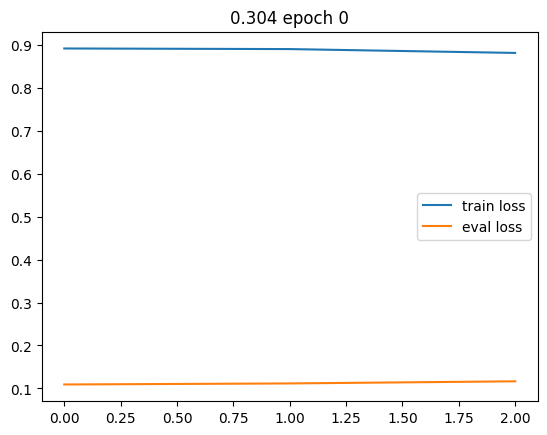

  0%|          | 3/5000 [18:22<509:48:05, 367.28s/it]

In [ ]:
epochs = 5000
bpdecay = 0.0001
replacement_prob = 0.5
grad_clip = 5
MSE_min = np.Inf
eval_min = np.Inf
MSE_accum = []
bp_decay = params.bpdecay
model = MainModel().to(device).float()
epoch_best = 0
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=2e-4, lr=1e-4)
scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)
model, scheduler, optimizer = load_checkpoint_run()
train_loss = []
eval_loss = []

for epoch in tqdm(range(epochs)):
    model.train()
    curr_loss1 = 0
    for iteration, data in enumerate(train_loader):
        model.zero_grad()
        beacons0, active0, measurement, motion, location = data
        beacons0 = beacons0[:, 0].to(device).float()
        beacons0[torch.isnan(beacons0)] = 0
        active = active0[:, 0].squeeze(2).to(device).float()
        #replacement_mask = (active == 0) & (torch.rand_like(active, dtype=torch.float) < replacement_prob)
        #active[replacement_mask] = 1
        measurement = measurement.to(device).float()
        motion = motion.to(device).float()
        beacons = (beacons0 - beacons_mu) / beacons_std
        location = location.to(device).float()
        loss, _, pred = model.step(motion, measurement, beacons, location, 0.0001, active)
        curr_loss1 += loss.to('cpu').detach().numpy() / train_numbers
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
    train_loss.append(curr_loss1)

    model.eval()
    curr_loss2 = 0
    y_pred = []
    y_true = []
    z_pred = []
    with torch.no_grad():
        for iteration, data in enumerate(eval_loader):
            beacons0, active0, measurement, motion, location = data
            beacons0 = beacons0[:, 0].to(device).float()
            beacons0[torch.isnan(beacons0)] = 0
            active = active0[:, 0].squeeze(2).to(device).float()
            #replacement_mask = (active == 0) & (torch.rand_like(active, dtype=torch.float) < replacement_prob)
            #active[replacement_mask] = 1
            measurement = measurement.to(device).float()
            motion = motion.to(device).float()
            beacons = (beacons0 - beacons_mu) / beacons_std
            location = location.to(device).float()
            lossx, _, pred = model.step(motion, measurement, beacons, location, 0.0001, active)
            curr_loss2 += lossx.to('cpu').detach().numpy() / eval_numbers
            y_true_curr = location[:, :, :2]
            y_pred_curr = pred[:, :, :2] * model.map_size
            y_true.extend(y_true_curr.to('cpu').numpy())
            y_pred.extend(y_pred_curr.detach().to('cpu').numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eval_loss.append(curr_loss2)

    y_true = y_true.reshape(len(y_true), track_len, 2)
    y_pred = y_pred.reshape(len(y_pred), track_len, 2)

    X = (y_pred[:, :-1] - y_true[:, 1:]).reshape(y_pred.shape[0]*(track_len-1), 2)
    MSE = (X**2).sum(axis=-1).mean()
    if MSE < MSE_min:
        MSE_min = MSE
    if curr_loss2 < eval_min:
        epoch_best = epoch
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        filepath='dec_project.ptm'
        torch.save(state, filepath)
        eval_min = curr_loss2

    print('epoch, MSE', epoch, np.round(MSE, 2), 'min MSE', np.round(MSE_min, 2))#, np.round(MSE_MKF, 2))
    MSE_accum.append(MSE)

    clear_output(True)
    plt.figure()
    plt.title(str(np.round(MSE_min, 4)) + ' epoch ' + str(epoch_best))
    plt.plot(train_loss, label='train loss')
    plt.plot(eval_loss, label='eval loss')
    #plt.plot(MSE_accum, label='MSE')
    plt.legend()
    plt.show()

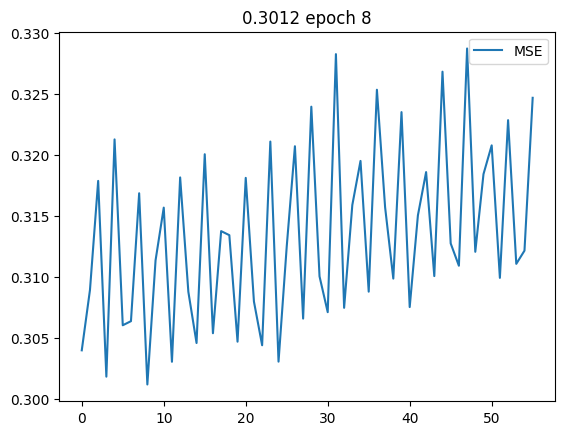

In [13]:
plt.figure()
plt.title(str(np.round(MSE_min, 4)) + ' epoch ' + str(epoch_best))
#plt.plot(train_loss, label='train loss')
#plt.plot(eval_loss, label='eval loss')
plt.plot(MSE_accum, label='MSE')
plt.legend()
plt.show()

In [14]:
def load_checkpoint(filepath='dec_project.ptm'):
    checkpoint = torch.load(filepath)
    print('epoch: ', checkpoint['epoch'])
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    for parameter in model.parameters():
        parameter.requires_grad = False
    return model

bp_decay = 1e-4 #params.bpdecay
model = MainModel().to(device).float()
model = load_checkpoint()
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for iteration, data in enumerate(test_loader):
        beacons0, active0, measurement, motion, location = data
        beacons0 = beacons0[:, 0].to(device).float()
        beacons0[torch.isnan(beacons0)] = 0
        active = active0[:, 0].squeeze(2).to(device).float()
        #replacement_mask = (active == 0) & (torch.rand_like(active, dtype=torch.float) < replacement_prob)
        #active[replacement_mask] = 1
        measurement = measurement.to(device).float()
        motion = motion.to(device).float()
        beacons = (beacons0 - beacons_mu) / beacons_std
        location = location.to(device).float()
        lossx, _, pred = model.step(motion, measurement, beacons, location, 0.0001, active)
        curr_loss2 += lossx.to('cpu').detach().numpy() / eval_numbers
        y_true_curr = location[:, :, :2]
        y_pred_curr = pred[:, :, :2] * model.map_size
        y_true.extend(y_true_curr.to('cpu').numpy())
        y_pred.extend(y_pred_curr.detach().to('cpu').numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true = y_true.reshape(len(y_true), track_len, 2)
y_pred = y_pred.reshape(len(y_pred), track_len, 2)

X = (y_pred - y_true).reshape(y_pred.shape[0]*track_len, 2)
MSE = (X**2).sum(axis=-1).mean()
print(MSE)

epoch:  8
0.20630503


(0.0, 10.0)

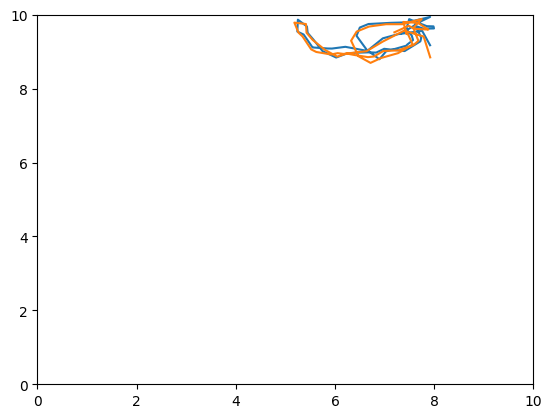

In [20]:
idx = 29
plt.plot(y_true[idx, :, 0], y_true[idx, :, 1])
plt.plot(y_pred[idx, :, 0], y_pred[idx, :, 1])
plt.xlim(0, 10)
plt.ylim(0, 10)

In [15]:
def load_checkpoint(filepath='dec_project.ptm'):
    checkpoint = torch.load(filepath)
    print('epoch: ', checkpoint['epoch'])
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    for parameter in model.parameters():
        parameter.requires_grad = False
    return model
    
params = ModelParams()
bp_decay = params.bpdecay
model = MainModel().to(device).float()
model = load_checkpoint()
model.eval()

#for look_back in [1, 5, 10, 20, 30, 40, 50]:
for look_back in [50]:
    y_pred = []
    y_true = []
    all_atts = []
    all_active = []
    with torch.no_grad():
        for iteration, data in enumerate(test_loader):
            beacons0, active0, measurement, motion, location = data
            beacons0 = beacons0[:, 0].to(device).float()
            active = active0[:, 0].squeeze(2).to(device).float()
            #active = torch.ones_like(active0[:, 0].squeeze(2)).to(device).float()
            measurement = measurement.to(device).float()
            motion = motion.to(device).float()
            beacons = (beacons0 - beacons_mu) / beacons_std
            location = location.to(device).float()
            att, pred = model.test(motion, measurement, beacons, active=active, look_back=look_back)
            y_true_curr = location[:, :, :2]
            y_true_curr = location[:, :, :2]
            y_pred_curr = pred[:, :, :2] * model.map_size
            y_true.extend(y_true_curr.to('cpu').numpy())
            y_pred.extend(y_pred_curr.detach().to('cpu').numpy())
            all_atts.extend(att.detach().to('cpu').numpy())
            all_active.extend(active.detach().to('cpu').numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    all_atts = np.array(all_atts)
    all_active = np.array(all_active)

    y_true = y_true.reshape(len(y_true), track_len, 2)
    y_pred = y_pred.reshape(len(y_pred), track_len, 2)

    X = (y_pred[:, :-1] - y_true[:, 1:]).reshape(y_pred.shape[0]*(track_len-1), 2)
    MSE_mean = (X**2).sum(axis=-1).mean()
    MSE_std = (X**2).sum(axis=-1).std()
    FSE_mean = (((y_pred[:, :-1] - y_true[:, 1:])[:, -1]**2).sum(axis=-1)**0.5).mean()
    FSE_std = (((y_pred[:, :-1] - y_true[:, 1:])[:, -1]**2).sum(axis=-1)**0.5).std()
    print(look_back, MSE_mean, MSE_std, FSE_mean, FSE_std)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


50 0.5607700013711411 3.2492979455737494 0.3377828373070172 0.24845101199315076
